<a href="https://colab.research.google.com/github/PeirongMa/chatgpt-sms/blob/main/bank_deposit_change_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from google.colab import files
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import statsmodels.api as sm

### Process the raw data into suitable format

In [ ]:


# specify the folder path where CSV files are stored
folder_path = "/content/2022"

# get a list of all CSV files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# create an empty list to store the dataframes
dfs = []

# read in each CSV file as a dataframe and append to the dfs list
for file in file_list:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    if len(dfs) == 0:
        # for the first dataframe, store the column names
        cols = list(df.columns)
        dfs.append(df)
    else:
        # for subsequent dataframes, only read in columns that are not already present
        new_cols = [col for col in df.columns if col not in cols]
        if len(new_cols) > 0:
            df = pd.read_csv(file_path, usecols=new_cols)
            dfs.append(df)

# concatenate all dataframes in the dfs list into a single dataframe
final_df = pd.concat(dfs, axis=1)




In [ ]:
final_df



,ABCUBK,ABCUOTH,ABCXBK,ABCXOTH,ADDNONII,ADDNONINTEXP,ASCEOTH,ASCERES,ASDROTH,ASDRRES,...,TTNMNUM,UC,UCCOMRE,UCCOMRES,UCCOMREU,UCCRCD,UCLOC,UCOTHER,UCOVER1,UCSC
0,NaN,NaN,NaN,NaN,558,1373,NaN,NaN,NaN,NaN,...,0,11604,941.0,861.0,80.0,0.0,785.0,9878.0,0.0,NaN
1,NaN,NaN,NaN,NaN,1634,2435,NaN,NaN,NaN,NaN,...,0,47671,13824.0,13824.0,0.0,26.0,9699.0,24122.0,25721.0,NaN
2,NaN,NaN,NaN,NaN,311,1288,NaN,NaN,NaN,NaN,...,0,23164,822.0,822.0,0.0,935.0,2045.0,19362.0,0.0,NaN
3,NaN,NaN,NaN,NaN,586,1580,NaN,NaN,NaN,NaN,...,0,24562,2785.0,2785.0,0.0,428.0,4819.0,16530.0,0.0,NaN
4,NaN,NaN,NaN,NaN,8862,14509,NaN,NaN,NaN,NaN,...,14,656536,194266.0,194266.0,0.0,12241.0,86918.0,363111.0,459561.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4768,NaN,NaN,NaN,NaN,10,610,NaN,NaN,NaN,NaN,...,0,3410,2928.0,2928.0,0.0,0.0,0.0,482.0,0.0,NaN
4769,NaN,NaN,NaN,NaN,1677,3627,NaN,NaN,NaN,NaN,...,0,82433,30700.0,30700.0,0.0,1695.0,28339.0,21699.0,47265.0,NaN
4770,NaN,NaN,NaN,NaN,890,2390,NaN,NaN,NaN,NaN,...,0,21729,8847.0,8847.0,0.0,0.0,7547.0,5335.0,0.0,NaN
4771,NaN,NaN,NaN,NaN,562,929,NaN,NaN,NaN,NaN,...,0,3539,1359.0,1183.0,176.0,0.0,1719.0,461.0,1137.0,NaN


In [ ]:
t2020.to_csv('2022t_file.csv', index=False)
files.download('2022t_file.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


def process_data_files(file_names):
    # loop over each pair of file names
    for i in range(0, len(file_names), 2):
        # read in the two data files for this pair
        data1 = pd.read_csv(file_names[i])
        data2 = pd.read_csv(file_names[i+1])

        # merge the two dataframes and perform data cleaning
        merged_df = pd.merge(data1, data2[['NAME', 'DEP']], on='NAME', how='left')
        merged_df.drop_duplicates(subset=[ 'NAME'], inplace=True)
        merged_df['change_depot'] = merged_df['DEP_x']-merged_df['DEP_y']
        nan_pct = merged_df.isna().sum() / len(merged_df) * 100
        zero_pct = (merged_df == 0).sum() / len(merged_df) * 100
        same_value_pct = (merged_df.apply(lambda col: col.value_counts(normalize=True).max()) * 100)
        mask = ((nan_pct >= 20) | (zero_pct >= 20) | (same_value_pct >= 20))
        merged_df.drop(merged_df.columns[mask], axis=1, inplace=True)
        merged_df = merged_df.dropna(axis=0)
        merged_df = merged_df.set_index('NAME')
    return merged_df




In [ ]:
file_names = ["2001q3_file .csv", "2001q4_file.csv"]



In [ ]:
data2001 = process_data_files(file_names)

In [ ]:
data2001

,ADDNONII,ADDNONINTEXP,ASSET,DEP_x,EDEPDOM,EINTEXP,ELNATR,EOTHNINT,EPREMAGG,ESAL,...,SCRDEBT,SCUS,SCUSO,TRN,TRNIPCOC,TRNMUNI,UC,UCOTHER,DEP_y,change_depot
NAME,,,,,,,,,,,,,,,,,,,,,
PROGRESSIVE BANK NA,286,1041,183166,158131,3853.0,4109.0,360.0,989.0,507.0,1685.0,...,63801.0,40769,39028,39899.0,34246.0,5546.0,17745,5555.0,170947.0,-12816.0
FARMERS STATE BANK,175,405,80756,62379,1736.0,1935.0,60.0,405.0,175.0,975.0,...,26164.0,16287,16287,14789.0,13116.0,1673.0,5737,2731.0,63667.0,-1288.0
FIRST BANK,445,507,61227,53416,1518.0,1645.0,27.0,500.0,288.0,950.0,...,6510.0,4391,4134,12889.0,11398.0,1057.0,3796,1137.0,57466.0,-4050.0
WOODFORD STATE BANK,122,274,77724,70622,2189.0,2241.0,90.0,274.0,206.0,933.0,...,4625.0,3402,3402,12530.0,11298.0,1232.0,4395,828.0,73658.0,-3036.0
PORTAGE COUNTY BANK,193,270,43399,38108,1089.0,1100.0,36.0,270.0,103.0,586.0,...,7410.0,5210,4209,7628.0,7324.0,304.0,4525,1297.0,40355.0,-2247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JEFFERSON SECURITY BANK,326,1296,167966,154970,4098.0,4142.0,90.0,1296.0,674.0,2206.0,...,25692.0,22352,21826,56235.0,37530.0,18683.0,29188,18239.0,163754.0,-8784.0
CAPON VALLEY BANK,201,734,112342,99922,3163.0,3237.0,165.0,734.0,360.0,1106.0,...,9335.0,4790,4790,17341.0,16503.0,838.0,4785,4785.0,101555.0,-1633.0
G W JONES EXCHANGE BANK,104,406,52286,47311,1245.0,1311.0,19.0,406.0,253.0,877.0,...,1510.0,1510,0,11878.0,11136.0,742.0,5184,293.0,51040.0,-3729.0


In [ ]:
file_names = ["2008q3_file .csv", "2008q4_file.csv"]

In [ ]:
data2008 = process_data_files(file_names)

In [ ]:
file_names = ["2022q3_file.csv", "2022q4_file.csv"]

In [ ]:
data2022 = process_data_files(file_names)

In [ ]:
merged_df = pd.concat([data2001,data2008,data2022], axis=0, ignore_index=True)


In [ ]:
merged_df

,ADDNONII,ADDNONINTEXP,ASSET,DEP_x,EDEPDOM,EINTEXP,ELNATR,EOTHNINT,EPREMAGG,ESAL,...,SCNM5T15,ASSET.1,DEP.1,ICHBAL,IOTHII,NETINBM,DEPSMB,DEPSMRN,NETINC.1,NTRTMMED
0,286,1041,183166,158131,3853.0,4109.0,360.0,989.0,507.0,1685.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,175,405,80756,62379,1736.0,1935.0,60.0,405.0,175.0,975.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,445,507,61227,53416,1518.0,1645.0,27.0,500.0,288.0,950.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,122,274,77724,70622,2189.0,2241.0,90.0,274.0,206.0,933.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,193,270,43399,38108,1089.0,1100.0,36.0,270.0,103.0,586.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,226,1165,262061,227154,561.0,800.0,NaN,1165.0,376.0,2737.0,...,6802.0,262061.0,227154.0,109.0,40.0,1652.0,8615.0,252.0,1652.0,5777.0
16502,379,299,75196,67570,92.0,92.0,NaN,299.0,114.0,574.0,...,0.0,75196.0,67570.0,109.0,2.0,122.0,2344.0,124.0,122.0,1791.0
16503,2236,5747,1866957,1769119,3507.0,3507.0,NaN,5747.0,932.0,7411.0,...,56053.0,1866957.0,1769119.0,2384.0,79.0,17649.0,21380.0,396.0,17649.0,35755.0
16504,701,1780,200966,181387,396.0,432.0,NaN,1780.0,659.0,2470.0,...,2429.0,200966.0,181387.0,111.0,43.0,1434.0,11298.0,413.0,1434.0,19997.0


In [ ]:
merged_df = merged_df.dropna(axis=1)

In [ ]:
def is_numeric(value):
    if pd.isna(value):
        return False
    try:
        float(value)
        return True
    except ValueError:
        return False

In [ ]:
numeric_df = merged_df.applymap(is_numeric)

# drop columns that contain only non-numeric values (i.e. all cells are letters)
non_numeric_cols = (numeric_df == False).all()
merged_df = merged_df.loc[:, ~non_numeric_cols]

In [ ]:
merged_df['change%'] = merged_df['change_depot']/merged_df['DEP_x']

In [ ]:
exclude_cols = ['ID', 'NAME', 'DEP_x','change_depot','DEP_y','RISDATE','change%']

In [ ]:
included_cols = [col for col in merged_df.columns if col not in exclude_cols]
data = merged_df[included_cols]

In [ ]:
data

,ADDNONII,ADDNONINTEXP,ASSET,EDEPDOM,EINTEXP,EOTHNINT,EPREMAGG,ESAL,IBEFXTR,ILNDOM,...,SC,SCAF,SCPLEDGE,SCRDEBT,SCUS,SCUSO,TRN,TRNIPCOC,UC,UCOTHER
0,286,1041,183166,3853.0,4109.0,989.0,507.0,1685.0,1645.0,6161.0,...,63801,54469,28595.0,63801.0,40769,39028,39899.0,34246.0,17745,5555.0
1,175,405,80756,1736.0,1935.0,405.0,175.0,975.0,632.0,3195.0,...,26214,26214,3898.0,26164.0,16287,16287,14789.0,13116.0,5737,2731.0
2,445,507,61227,1518.0,1645.0,500.0,288.0,950.0,276.0,2678.0,...,6510,6510,1808.0,6510.0,4391,4134,12889.0,11398.0,3796,1137.0
3,122,274,77724,2189.0,2241.0,274.0,206.0,933.0,518.0,3817.0,...,4624,0,200.0,4625.0,3402,3402,12530.0,11298.0,4395,828.0
4,193,270,43399,1089.0,1100.0,270.0,103.0,586.0,566.0,2068.0,...,7412,0,0.0,7410.0,5210,4209,7628.0,7324.0,4525,1297.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,226,1165,262061,561.0,800.0,1165.0,376.0,2737.0,1652.0,5698.0,...,68548,66110,41122.0,68548.0,58410,11458,125457.0,117578.0,53722,50482.0
16502,379,299,75196,92.0,92.0,299.0,114.0,574.0,122.0,493.0,...,26910,0,5025.0,26869.0,26828,0,33590.0,30501.0,4414,3417.0
16503,2236,5747,1866957,3507.0,3507.0,5747.0,932.0,7411.0,17649.0,18311.0,...,925496,925391,362792.0,925392.0,851863,851863,100471.0,66647.0,214235,102940.0
16504,701,1780,200966,396.0,432.0,1780.0,659.0,2470.0,1434.0,5544.0,...,42761,42761,6666.0,42761.0,16776,13986,69141.0,65518.0,23833,5522.0


In [ ]:
data = data.drop(['ZIP',"CERT",'RSSDID','IDLNCORR'],axis =1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

def drop_high_vif_cols(df, threshold=5.0, sample_size=30):
    """
    Iteratively drops columns from the input DataFrame with high VIF values until all VIF values are below the threshold.
    For each iteration, a random sample of columns of size 'sample_size' is selected to calculate the VIF values.

    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame containing the data
    threshold : float, default 5.0
        The threshold VIF value above which columns will be dropped
    sample_size : int, default 30
        The number of columns to select as a random sample for each iteration

    Returns:
    --------
    pandas DataFrame
        The final DataFrame after dropping columns with high VIF values
    """
    # create a copy of the input DataFrame to work on
    df_vif = df.copy()

    # create a loop to drop columns with high VIF values iteratively
    while True:
        # select a random sample of columns to calculate VIF
        columns = np.random.choice(df_vif.columns, size=min(sample_size, df_vif.shape[1]), replace=False)
        df_vif_sample = df_vif[columns]

        # calculate VIF values for the selected columns
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(df_vif_sample.values, i) for i in range(df_vif_sample.shape[1])]
        vif["features"] = df_vif_sample.columns

        # find the column with the highest VIF value
        max_vif = vif["VIF Factor"].max()
        max_vif_idx = vif["VIF Factor"].idxmax()

        # if the highest VIF value is below the threshold, break out of the loop
        if max_vif < threshold:
            break

        # drop the column with the highest VIF value from the DataFrame
        df_vif = df_vif.drop(df_vif_sample.columns[max_vif_idx], axis=1)

    # return the final DataFrame after dropping columns with high VIF values
    return df_vif


In [ ]:
df_vif = drop_high_vif_cols(data)

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [round(variance_inflation_factor(df_vif.values, i), 2) for i in range(df_vif.shape[1])]
vif["features"] = df_vif.columns



In [ ]:
df_vif

,IOTNII,CD1T3,CD3T12,CDOV3S,DDT,EQCCOMPI,EQCS,NTRMUNI,ASTEMPM,EEFFR,...,NTLNLSR,ROAPTX,ROE,ROEINJR,LNCONOTH,LNEXAMT,LNRECONS,LNRS1T3,LNRS3LES,SCPLEDGE
0,278.0,4949.0,5582.0,3234.0,15718.0,806.0,962.0,5481.0,2.289575,53.444220,...,0.206844,1.744677,13.84,7.284781,13139.0,4785.0,191.0,4854.0,1215.0,28595.0
1,164.0,2884.0,1558.0,3147.0,7498.0,403.0,150.0,3896.0,2.990963,63.729508,...,0.090004,1.456811,7.32,5.139430,4111.0,78.0,574.0,4640.0,2207.0,3898.0
2,102.0,2337.0,2509.0,559.0,7596.0,182.0,1043.0,1204.0,1.700750,81.443299,...,0.132766,0.804367,5.92,-0.622486,2663.0,385.0,1743.0,6967.0,2217.0,1808.0
3,21.0,1743.0,3768.0,536.0,7464.0,0.0,64.0,431.0,2.507226,61.301518,...,0.079407,1.480613,13.88,13.875427,7406.0,1541.0,3037.0,10551.0,3388.0,200.0
4,193.0,1092.0,1394.0,0.0,5479.0,0.0,125.0,2161.0,2.169950,61.434978,...,0.104543,1.757580,16.01,9.619055,1675.0,756.0,3052.0,3526.0,2076.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,257.0,2388.0,1832.0,751.0,56083.0,-4392.0,504.0,27398.0,7.487457,72.410291,...,0.002422,0.883060,10.22,0.321695,1789.0,6024.0,6467.0,1954.0,292.0,41122.0
16502,379.0,0.0,0.0,75.0,18854.0,-134.0,200.0,2195.0,6.266333,88.838884,...,0.000000,0.206526,2.21,2.210240,223.0,0.0,685.0,301.0,0.0,5025.0
16503,1833.0,35582.0,59786.0,1524.0,71537.0,-123425.0,1800.0,215705.0,14.935656,38.454191,...,0.016027,1.455153,16.38,16.377795,6944.0,2399.0,76308.0,4502.0,947.0,362792.0
16504,615.0,1124.0,1638.0,4052.0,55232.0,-2908.0,180.0,8483.0,4.275872,72.372107,...,-0.023226,1.212002,10.60,6.446920,10128.0,832.0,15786.0,2535.0,2246.0,6666.0


In [ ]:
df_vif = data

In [ ]:
import pandas as pd

# Create a new DataFrame with a binary target column
new_df = pd.DataFrame()
new_df['target'] = merged_df['change%']
new_df['target2'] = merged_df['change_depot']
# Add the input features to the new DataFrame
new_df = pd.concat([new_df, df_vif], axis=1)



In [ ]:
exclude_col = ['target', 'target2']
all_cols = new_df.columns.tolist()
cols_less_one = [col for col in all_cols if col not in exclude_col]


In [ ]:
from sklearn.preprocessing import StandardScaler

exclude_col = ['target', 'target2']
all_cols = new_df.columns.tolist()
cols_less_one = [col for col in all_cols if col not in exclude_col]

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y = new_df['target']

# Instantiate a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the input features
scaler.fit(X)

# Transform the input features using the scaler
X_standardized = scaler.transform(X)

# Create a new dataframe with the standardized input features
df_standardized = pd.DataFrame(X_standardized, columns=X.columns)

# Add the target variable back to the standardized dataframe
df_standardized['target'] = y
df_standardized['target2'] = new_df['target2']

In [ ]:
df_standardized

,ADDNONII,ADDNONINTEXP,ASSET,EDEPDOM,EINTEXP,EOTHNINT,EPREMAGG,ESAL,IBEFXTR,ILNDOM,...,SCPLEDGE,SCRDEBT,SCUS,SCUSO,TRN,TRNIPCOC,UC,UCOTHER,target,target2
0,-0.054940,-0.057257,-0.047432,-0.060287,-0.049253,-0.055404,-0.049668,-0.050888,-0.045015,-0.068261,...,-0.045261,-0.039028,-0.035769,-0.039619,-0.037108,-0.036387,-0.050641,-0.046365,-0.081047,-12816.0
1,-0.055293,-0.059248,-0.049716,-0.076231,-0.055415,-0.057279,-0.053662,-0.052794,-0.048260,-0.073131,...,-0.053412,-0.042578,-0.038508,-0.043476,-0.039551,-0.038640,-0.051157,-0.046668,-0.020648,-1288.0
2,-0.054436,-0.058929,-0.050151,-0.077873,-0.056237,-0.056974,-0.052303,-0.052862,-0.049400,-0.073980,...,-0.054102,-0.044432,-0.039839,-0.045537,-0.039736,-0.038823,-0.051240,-0.046839,-0.075820,-4050.0
3,-0.055461,-0.059658,-0.049783,-0.072819,-0.054548,-0.057699,-0.053290,-0.052907,-0.048625,-0.072110,...,-0.054633,-0.044610,-0.039950,-0.045661,-0.039771,-0.038833,-0.051214,-0.046873,-0.042989,-3036.0
4,-0.055236,-0.059671,-0.050549,-0.081103,-0.057781,-0.057712,-0.054529,-0.053839,-0.048471,-0.074982,...,-0.054699,-0.044347,-0.039747,-0.045524,-0.040248,-0.039257,-0.051209,-0.046822,-0.058964,-2247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,-0.055131,-0.056869,-0.045673,-0.085080,-0.058632,-0.054839,-0.051244,-0.048064,-0.044993,-0.069021,...,-0.041127,-0.038580,-0.033795,-0.044295,-0.028781,-0.027505,-0.049094,-0.041537,-0.011706,-2659.0
16502,-0.054645,-0.059580,-0.049840,-0.088612,-0.060638,-0.057619,-0.054396,-0.053871,-0.049893,-0.077568,...,-0.053040,-0.042512,-0.037329,-0.046238,-0.037722,-0.036786,-0.051214,-0.046594,-0.026521,-1792.0
16503,-0.048753,-0.042525,-0.009887,-0.062893,-0.050960,-0.040131,-0.044556,-0.035514,0.006237,-0.048311,...,0.065037,0.042246,0.054983,0.098224,-0.031213,-0.032933,-0.042195,-0.035899,-0.012254,-21679.0
16504,-0.053624,-0.054943,-0.047035,-0.086323,-0.059675,-0.052865,-0.047840,-0.048780,-0.045691,-0.069274,...,-0.052499,-0.041013,-0.038453,-0.043866,-0.034262,-0.033054,-0.050379,-0.046368,-0.000805,-146.0


In [ ]:
new_df = df_standardized
new_df['target'] = new_df['target'].apply(lambda x: 1 if x <=-0.30 else 0)

In [ ]:
new_df['target'] = new_df['target'].apply(lambda x: 1 if x <=-0.30 else 0)

In [ ]:
value_counts = new_df['target'].value_counts(normalize=True)

# print the percentage of 1's and 0's in the 'target' column
print("Percentage of 1's:", value_counts[1] * 100)
print("Percentage of 0's:", value_counts[0] * 100)

Percentage of 1's: 2.0901490367139224
Percentage of 0's: 97.90985096328609


In [ ]:
new_df[cols_less_one]

,ADDNONII,ADDNONINTEXP,ASSET,EDEPDOM,EINTEXP,EOTHNINT,EPREMAGG,ESAL,IBEFXTR,ILNDOM,...,SC,SCAF,SCPLEDGE,SCRDEBT,SCUS,SCUSO,TRN,TRNIPCOC,UC,UCOTHER
0,286,1041,183166,3853.0,4109.0,989.0,507.0,1685.0,1645.0,6161.0,...,63801,54469,28595.0,63801.0,40769,39028,39899.0,34246.0,17745,5555.0
1,175,405,80756,1736.0,1935.0,405.0,175.0,975.0,632.0,3195.0,...,26214,26214,3898.0,26164.0,16287,16287,14789.0,13116.0,5737,2731.0
2,445,507,61227,1518.0,1645.0,500.0,288.0,950.0,276.0,2678.0,...,6510,6510,1808.0,6510.0,4391,4134,12889.0,11398.0,3796,1137.0
3,122,274,77724,2189.0,2241.0,274.0,206.0,933.0,518.0,3817.0,...,4624,0,200.0,4625.0,3402,3402,12530.0,11298.0,4395,828.0
4,193,270,43399,1089.0,1100.0,270.0,103.0,586.0,566.0,2068.0,...,7412,0,0.0,7410.0,5210,4209,7628.0,7324.0,4525,1297.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,226,1165,262061,561.0,800.0,1165.0,376.0,2737.0,1652.0,5698.0,...,68548,66110,41122.0,68548.0,58410,11458,125457.0,117578.0,53722,50482.0
16502,379,299,75196,92.0,92.0,299.0,114.0,574.0,122.0,493.0,...,26910,0,5025.0,26869.0,26828,0,33590.0,30501.0,4414,3417.0
16503,2236,5747,1866957,3507.0,3507.0,5747.0,932.0,7411.0,17649.0,18311.0,...,925496,925391,362792.0,925392.0,851863,851863,100471.0,66647.0,214235,102940.0
16504,701,1780,200966,396.0,432.0,1780.0,659.0,2470.0,1434.0,5544.0,...,42761,42761,6666.0,42761.0,16776,13986,69141.0,65518.0,23833,5522.0


### Model sellection and testing the impact of data precossing result

In [ ]:
import statsmodels.api as sm

# Reset the indices of new_df and merged_df
new_df = new_df.reset_index(drop=True)
merged_df = merged_df.reset_index(drop=True)

# Define the independent variables
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y = new_df['target2']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                target2   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     849.1
Date:                Thu, 11 May 2023   Prob (F-statistic):               0.00
Time:                        18:52:37   Log-Likelihood:            -2.4020e+05
No. Observations:               16506   AIC:                         4.807e+05
Df Residuals:                   16378   BIC:                         4.816e+05
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.722e+05   2.05e+05     -0.838   

Average accuracy: 0.9458373070499055


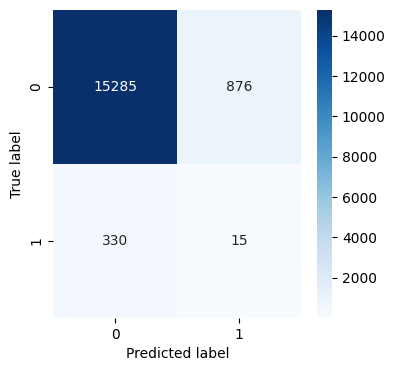

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target']

# Create a logistic regression object with increased max_iter
clf = LogisticRegression(max_iter=12000)

# Define the probability threshold
prob_thresh = 0.05

# Define the number of folds for cross-validation
k = 10

# Create a KFold object for cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over the k folds and train/test the classifier
scores = []
y_pred_all = []
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)

    # Predict the target values for the testing data based on the probability threshold
    y_pred_prob = clf.predict_proba(X_test)
    y_pred = np.where(y_pred_prob[:,1] > prob_thresh, 1, 0)

    # Compute the accuracy score for this fold and store it
    fold_score = accuracy_score(y_test, y_pred)
    scores.append(fold_score)

    # Store the predicted target values for this fold
    y_pred_all.extend(y_pred)

# Compute the average accuracy score over all folds
avg_score = sum(scores) / k
print("Average accuracy:", avg_score)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_all)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()




Accuracy: 0.9624470018170805


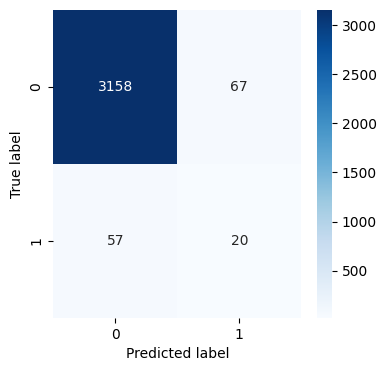

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define the input features (X) and target variable (y_true)
X = new_df[cols_less_one]
y_true = new_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=42)

# Create the decision tree model
model = DecisionTreeClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Accuracy: 0.9797092671108419


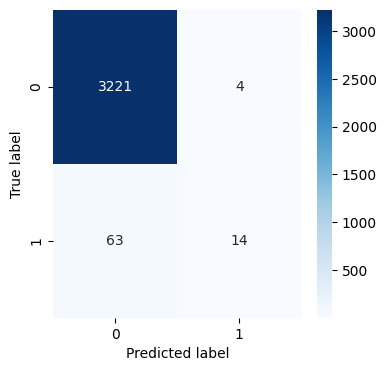

In [ ]:
## random forest

# Import the necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix



# Define the input features (X) and target variable (y_true)
X = new_df[cols_less_one]
y_true = new_df['target']


# Convert the data to a sparse matrix
X_sparse = csr_matrix(X.values)

# Split the data into training and testing sets
X_train_sparse, X_test_sparse, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# Create the random forest classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train_sparse, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test_sparse)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Load the new data into a pandas DataFrame
t2022 = pd.read_csv("2022q4t_file.csv")
t2022 = t2022.set_index("NAME")
t2022 = t2022[cols_less_one]
t2022 = t2022.dropna()
new_data = t2022

# Preserve the original index in a separate column
new_data['original_index'] = new_data.index

# Preprocess the new data in the same way as the training data
# ...

# Convert the preprocessed data into a sparse matrix format
new_data_sparse = csr_matrix(new_data[cols_less_one].values)

# Use the trained model to predict the labels of the new data
new_data_pred = rf_model.predict(new_data_sparse)

# Find the original index of the rows in new_data where the predicted label is 1
predicted_rows = new_data[new_data_pred == 1]['original_index']
print("Indices of rows with predicted label 1:", predicted_rows)


Indices of rows with predicted label 1: NAME
AMERICAN TRUST&SAVINGS BANK    AMERICAN TRUST&SAVINGS BANK
CAMP GROVE STATE BANK                CAMP GROVE STATE BANK
BANK OF NEW CAMBRIA                    BANK OF NEW CAMBRIA
FIRST STATE BANK                          FIRST STATE BANK
GRAND RIVERS COMMUNITY BANK    GRAND RIVERS COMMUNITY BANK
                                          ...             
FARMERS NB OF EMLENTON              FARMERS NB OF EMLENTON
LAMONT BANK OF ST JOHN              LAMONT BANK OF ST JOHN
BANKPROV                                          BANKPROV
THREAD BANK                                    THREAD BANK
M1 BANK                                            M1 BANK
Name: original_index, Length: 156, dtype: object


In [ ]:
predicted_rows.to_csv('predicted_ones.csv', index=False)
files.download('predicted_ones.csv')

# Neural Network works best for our problems : Testing for different optimizer and setting

Epoch 1/100
331/331 [==============================] - 2s 3ms/step - loss: 0.7966 - accuracy: 0.9370 - val_loss: 0.3775 - val_accuracy: 0.9780
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.2305 - accuracy: 0.9792 - val_loss: 0.1449 - val_accuracy: 0.9799
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1097 - accuracy: 0.9801 - val_loss: 0.0973 - val_accuracy: 0.9803
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0872 - accuracy: 0.9799 - val_loss: 0.0889 - val_accuracy: 0.9803
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0825 - accuracy: 0.9797 - val_loss: 0.0892 - val_accuracy: 0.9803
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0817 - accuracy: 0.9804 - val_loss: 0.0878 - val_accuracy: 0.9803
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0812 - accuracy: 0.9800 - val_loss: 0.0872 - val_accuracy: 0.9803

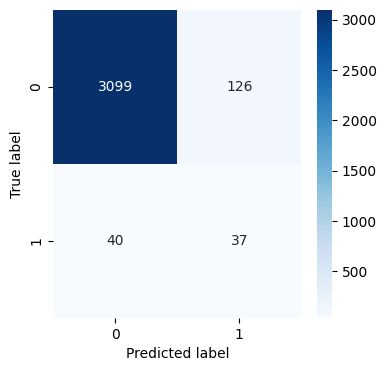

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target']

# Convert the target variable to a numpy array
y_true = np.array(y_true)

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_true, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the neural network architecture with L2 regularization
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])

# Predict the class probabilities on the test set
y_prob = model.predict(X_test)

# Threshold the probabilities to get binary predictions
y_pred = (y_prob > 0.03).astype(int)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

model.summary()

Epoch 1/100
331/331 [==============================] - 1s 2ms/step - loss: 0.2864 - accuracy: 0.9723 - val_loss: 0.0881 - val_accuracy: 0.9803
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0994 - accuracy: 0.9796 - val_loss: 0.0900 - val_accuracy: 0.9803
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0878 - accuracy: 0.9796 - val_loss: 0.0879 - val_accuracy: 0.9796
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9795 - val_loss: 0.0866 - val_accuracy: 0.9799
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0983 - accuracy: 0.9794 - val_loss: 0.0987 - val_accuracy: 0.9796
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0835 - accuracy: 0.9796 - val_loss: 0.0874 - val_accuracy: 0.9799
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0982 - accuracy: 0.9796 - val_loss: 0.0909 - val_accuracy: 0.9792

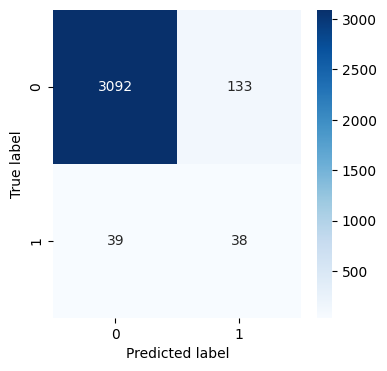

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target']

# Convert the target variable to a numpy array
y_true = np.array(y_true)

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_true, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the neural network architecture with L2 regularization
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dense(1, activation='sigmoid'))
# Compile the model with SGD optimizer
from tensorflow.keras.optimizers import SGD
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model with early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])

# Predict the class probabilities on the test set
y_prob = model.predict(X_test)

# Threshold the probabilities to get binary predictions
y_pred = (y_prob > 0.03).astype(int)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Epoch 1/100
331/331 [==============================] - 1s 2ms/step - loss: 1.8971 - accuracy: 0.9537 - val_loss: 0.2153 - val_accuracy: 0.9803
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1272 - accuracy: 0.9796 - val_loss: 0.0948 - val_accuracy: 0.9803
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0936 - accuracy: 0.9796 - val_loss: 0.0932 - val_accuracy: 0.9803
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0933 - accuracy: 0.9796 - val_loss: 0.0961 - val_accuracy: 0.9803
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0944 - accuracy: 0.9796 - val_loss: 0.0938 - val_accuracy: 0.9803
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0939 - accuracy: 0.9796 - val_loss: 0.0930 - val_accuracy: 0.9803
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0932 - accuracy: 0.9796 - val_loss: 0.0928 - val_accuracy: 0.9803

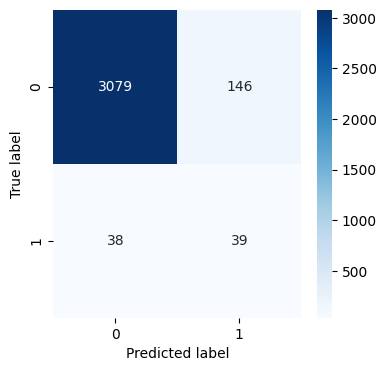

In [ ]:
"Best"

import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target']

# Convert the target variable to a numpy array
y_true = np.array(y_true)

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_true, test_size=0.20, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# Define the neural network architecture with L2 regularization
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.5)))
model.add(Dense(1, activation='sigmoid'))
# Compile the model with RMSprop optimizer
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(lr=0.002, rho=0.8)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

# Train the model with early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])

# Predict the class probabilities on the test set
y_prob = model.predict(X_test)

# Threshold the probabilities to get binary predictions
y_pred = (y_prob > 0.03).astype(int)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 2.2438 - accuracy: 0.8954 - val_loss: 0.3221 - val_accuracy: 0.9784
Epoch 2/100
291/291 [==============================] - 1s 5ms/step - loss: 0.1925 - accuracy: 0.9805 - val_loss: 0.1175 - val_accuracy: 0.9784
Epoch 3/100
291/291 [==============================] - 1s 4ms/step - loss: 0.0957 - accuracy: 0.9805 - val_loss: 0.0992 - val_accuracy: 0.9784
Epoch 4/100
291/291 [==============================] - 1s 4ms/step - loss: 0.0911 - accuracy: 0.9805 - val_loss: 0.1029 - val_accuracy: 0.9784
Epoch 5/100
291/291 [==============================] - 1s 4ms/step - loss: 0.0918 - accuracy: 0.9805 - val_loss: 0.1031 - val_accuracy: 0.9784
Epoch 6/100
291/291 [==============================] - 2s 6ms/step - loss: 0.0911 - accuracy: 0.9805 - val_loss: 0.1000 - val_accuracy: 0.9784
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.0905 - accuracy: 0.9805 - val_loss: 0.0995 - val_accuracy: 0.9784

Epoch 1/100
291/291 [==============================] - 1s 3ms/step - loss: 2.2290 - accuracy: 0.8925 - val_loss: 0.3156 - val_accuracy: 0.9784
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.1884 - accuracy: 0.9805 - val_loss: 0.1177 - val_accuracy: 0.9780
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.0964 - accuracy: 0.9805 - val_loss: 0.0994 - val_accuracy: 0.9784
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.0917 - accuracy: 0.9805 - val_loss: 0.1006 - val_accuracy: 0.9784
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.0917 - accuracy: 0.9805 - val_loss: 0.0994 - val_accuracy: 0.9784
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.0906 - accuracy: 0.9805 - val_loss: 0.1004 - val_accuracy: 0.9784
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.0918 - accuracy: 0.9805 - val_loss: 0.1007 - val_accuracy: 0.9784

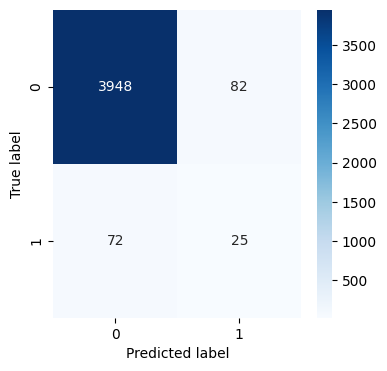

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target']

# Convert the target variable to a numpy array
y_true = np.array(y_true)

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set the initial accuracy threshold and flag
accuracy_threshold = 0.96
is_above_threshold = False

# Loop until the accuracy threshold is reached
while not is_above_threshold:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_true, test_size=0.25, random_state=42)

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Define the neural network architecture with L2 regularization
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.5)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with RMSprop optimizer
    rmsprop = RMSprop(lr=0.002, rho=0.8)
    model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

    # Train the model with early stopping to prevent overfitting
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])

    # Predict the class probabilities on the test set
    y_prob = model.predict(X_test)

    # Threshold the probabilities to get binary predictions
    y_pred = (y_prob > 0.03).astype(int)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Check if the accuracy threshold is met
    if accuracy >= accuracy_threshold:
        is_above_threshold = True

# Print the final accuracy and confusion matrix
print("Final accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Epoch 1/100
331/331 [==============================] - 3s 5ms/step - loss: 4.7270 - accuracy: 0.9309 - val_loss: 0.9443 - val_accuracy: 0.9856
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.3460 - accuracy: 0.9833 - val_loss: 0.1105 - val_accuracy: 0.9860
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0935 - accuracy: 0.9833 - val_loss: 0.0762 - val_accuracy: 0.9860
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0824 - accuracy: 0.9833 - val_loss: 0.0752 - val_accuracy: 0.9860
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0823 - accuracy: 0.9833 - val_loss: 0.0729 - val_accuracy: 0.9860
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0828 - accuracy: 0.9833 - val_loss: 0.0726 - val_accuracy: 0.9860
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0826 - accuracy: 0.9833 - val_loss: 0.0738 - val_accuracy: 0.9860

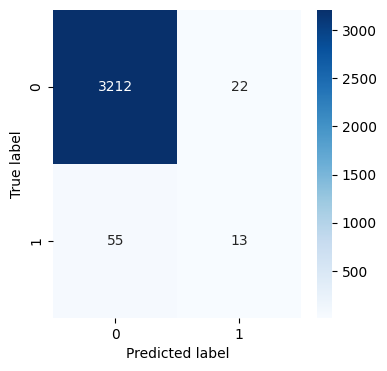

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target']

# Convert the target variable to a numpy array
y_true = np.array(y_true)

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_true, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the neural network architecture with L2 regularization
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.8)))
model.add(Dense(1, activation='sigmoid'))
# Compile the model with Nadam optimizer
from tensorflow.keras.optimizers import Nadam
nadam = Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['accuracy'])

# Train the model with early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])

# Predict the class probabilities on the test set
y_prob = model.predict(X_test)

# Threshold the probabilities to get binary predictions
y_pred = (y_prob > 0.05).astype(int)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Fold 1...
Epoch 1/100
334/334 [==============================] - 2s 3ms/step - loss: 2.1812 - accuracy: 0.7769 - val_loss: 0.4471 - val_accuracy: 0.9546
Epoch 2/100
334/334 [==============================] - 1s 3ms/step - loss: 0.3514 - accuracy: 0.9547 - val_loss: 0.2700 - val_accuracy: 0.9546
Epoch 3/100
334/334 [==============================] - 1s 3ms/step - loss: 0.2209 - accuracy: 0.9547 - val_loss: 0.1930 - val_accuracy: 0.9546
Epoch 4/100
334/334 [==============================] - 1s 4ms/step - loss: 0.1796 - accuracy: 0.9547 - val_loss: 0.1825 - val_accuracy: 0.9546
Epoch 5/100
334/334 [==============================] - 1s 4ms/step - loss: 0.1747 - accuracy: 0.9547 - val_loss: 0.1808 - val_accuracy: 0.9546
Epoch 6/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1743 - accuracy: 0.9547 - val_loss: 0.1799 - val_accuracy: 0.9546
Epoch 7/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1740 - accuracy: 0.9547 - val_loss: 0.1810 - val_accura

Epoch 1/100
334/334 [==============================] - 2s 3ms/step - loss: 2.0503 - accuracy: 0.8355 - val_loss: 0.3802 - val_accuracy: 0.9550
Epoch 2/100
334/334 [==============================] - 1s 3ms/step - loss: 0.2785 - accuracy: 0.9546 - val_loss: 0.2048 - val_accuracy: 0.9550
Epoch 3/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1827 - accuracy: 0.9546 - val_loss: 0.1751 - val_accuracy: 0.9550
Epoch 4/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1743 - accuracy: 0.9546 - val_loss: 0.1736 - val_accuracy: 0.9550
Epoch 5/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1739 - accuracy: 0.9546 - val_loss: 0.1738 - val_accuracy: 0.9550
Epoch 6/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1744 - accuracy: 0.9546 - val_loss: 0.1732 - val_accuracy: 0.9550
Epoch 7/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1738 - accuracy: 0.9546 - val_loss: 0.1727 - val_accuracy: 0.9550

Epoch 1/100
334/334 [==============================] - 2s 3ms/step - loss: 1.7185 - accuracy: 0.9552 - val_loss: 0.1824 - val_accuracy: 0.9542
Epoch 2/100
334/334 [==============================] - 1s 2ms/step - loss: 0.1743 - accuracy: 0.9547 - val_loss: 0.1675 - val_accuracy: 0.9546
Epoch 3/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1709 - accuracy: 0.9547 - val_loss: 0.1696 - val_accuracy: 0.9546
Epoch 4/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1712 - accuracy: 0.9547 - val_loss: 0.1650 - val_accuracy: 0.9546
Epoch 5/100
334/334 [==============================] - 1s 2ms/step - loss: 0.1721 - accuracy: 0.9547 - val_loss: 0.1654 - val_accuracy: 0.9546
Epoch 6/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1711 - accuracy: 0.9547 - val_loss: 0.1661 - val_accuracy: 0.9546
Epoch 7/100
334/334 [==============================] - 1s 2ms/step - loss: 0.1708 - accuracy: 0.9547 - val_loss: 0.1643 - val_accuracy: 0.9546

Epoch 1/100
334/334 [==============================] - 2s 4ms/step - loss: 1.8041 - accuracy: 0.9167 - val_loss: 0.2649 - val_accuracy: 0.9546
Epoch 2/100
334/334 [==============================] - 1s 2ms/step - loss: 0.1961 - accuracy: 0.9547 - val_loss: 0.1782 - val_accuracy: 0.9546
Epoch 3/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1738 - accuracy: 0.9547 - val_loss: 0.1734 - val_accuracy: 0.9546
Epoch 4/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1734 - accuracy: 0.9547 - val_loss: 0.1759 - val_accuracy: 0.9546
Epoch 5/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1732 - accuracy: 0.9547 - val_loss: 0.1736 - val_accuracy: 0.9546
Epoch 6/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1744 - accuracy: 0.9547 - val_loss: 0.1741 - val_accuracy: 0.9546
Epoch 7/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1732 - accuracy: 0.9547 - val_loss: 0.1718 - val_accuracy: 0.9546

Epoch 1/100
334/334 [==============================] - 2s 3ms/step - loss: 2.0875 - accuracy: 0.8672 - val_loss: 0.3154 - val_accuracy: 0.9546
Epoch 2/100
334/334 [==============================] - 1s 3ms/step - loss: 0.2166 - accuracy: 0.9547 - val_loss: 0.1787 - val_accuracy: 0.9546
Epoch 3/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1738 - accuracy: 0.9547 - val_loss: 0.1774 - val_accuracy: 0.9546
Epoch 4/100
334/334 [==============================] - 1s 3ms/step - loss: 0.1739 - accuracy: 0.9547 - val_loss: 0.1765 - val_accuracy: 0.9546
Epoch 5/100
334/334 [==============================] - 1s 4ms/step - loss: 0.1742 - accuracy: 0.9547 - val_loss: 0.1761 - val_accuracy: 0.9546
Epoch 6/100
334/334 [==============================] - 1s 4ms/step - loss: 0.1735 - accuracy: 0.9547 - val_loss: 0.1763 - val_accuracy: 0.9546
Epoch 7/100
334/334 [==============================] - 1s 4ms/step - loss: 0.1727 - accuracy: 0.9547 - val_loss: 0.1756 - val_accuracy: 0.9546

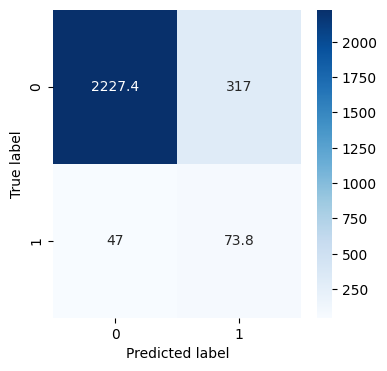

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one].values

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target'].values

# Convert the target variable to a numpy array
y_true = np.array(y_true)

# Standardize the input features
scaler = StandardScaler()

# Define the neural network architecture with L2 regularization
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.5)))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Set up k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the performance metrics for each fold
acc_per_fold = []
cm_per_fold = []

# Iterate over the folds
for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y_true)):
    print(f'Fold {fold+1}...')

    # Split the data into training and validation sets for this fold
    X_train, y_train = X[train_indices], y_true[train_indices]
    X_val, y_val = X[val_indices], y_true[val_indices]

    # Standardize the input features using the training set statistics
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Define the neural network
    model = create_model(X_train.shape[1])

    # Compile the model with RMSprop optimizer
    rmsprop = RMSprop(lr=0.002, rho=0.8)
    model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

    # Train the model with early stopping to prevent overfitting
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks=[es])

    # Predict the class probabilities on the validation set
    y_prob = model.predict(X_val_scaled)

    # Threshold the probabilities to get binary predictions
    y_pred = (y_prob > 0.05).astype(int)

    # Evaluate the model's performance on the validation set
    acc = accuracy_score(y_val, y_pred)
    acc_per_fold.append(acc)
    cm = confusion_matrix(y_val, y_pred)
    cm_per_fold.append(cm)

    print(f'Accuracy: {acc:.2f}')
    print(f'Confusion matrix:\n{cm}')

# Calculate the mean and standard deviation of the performance metrics across the folds
mean_acc = np.mean(acc_per_fold)
std_acc =np.std(acc_per_fold)
mean_cm = np.mean(cm_per_fold, axis=0)
std_cm = np.std(cm_per_fold, axis=0)

# Print the overall performance metrics
print(f'\nOverall accuracy: {mean_acc:.2f} +/- {std_acc:.2f}')
print(f'Overall confusion matrix:\n{mean_cm}')

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(mean_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



### Finding the best probablity threshold

Epoch 1/100
331/331 [==============================] - 5s 10ms/step - loss: 2.7022 - accuracy: 0.9312 - val_loss: 0.2143 - val_accuracy: 0.9803
Epoch 2/100
331/331 [==============================] - 3s 8ms/step - loss: 0.1301 - accuracy: 0.9796 - val_loss: 0.0974 - val_accuracy: 0.9803
Epoch 3/100
331/331 [==============================] - 2s 6ms/step - loss: 0.0973 - accuracy: 0.9796 - val_loss: 0.0948 - val_accuracy: 0.9803
Epoch 4/100
331/331 [==============================] - 2s 7ms/step - loss: 0.0963 - accuracy: 0.9796 - val_loss: 0.0941 - val_accuracy: 0.9803
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0964 - accuracy: 0.9796 - val_loss: 0.0937 - val_accuracy: 0.9803
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0971 - accuracy: 0.9796 - val_loss: 0.0938 - val_accuracy: 0.9803
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0956 - accuracy: 0.9796 - val_loss: 0.0956 - val_accuracy: 0.980

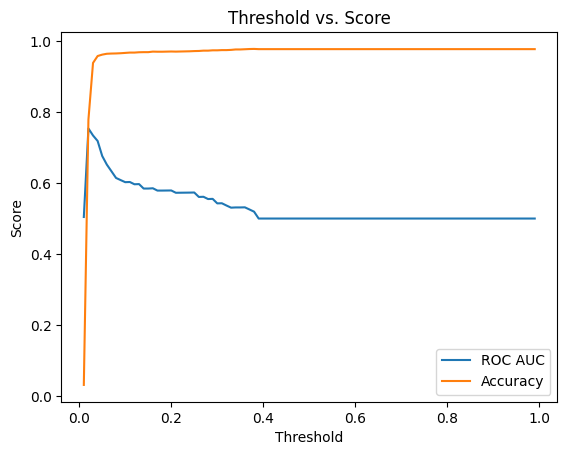

Best threshold (AUC): 0.02
Max ROC AUC: 0.7534038054968288
Best threshold (Accuracy): 0.38
Max Accuracy: 0.9772864930345245
Accuracy (AUC): 0.7783161720169595


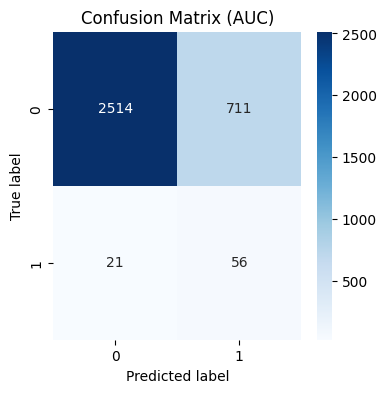

Accuracy (Accuracy): 0.9772864930345245


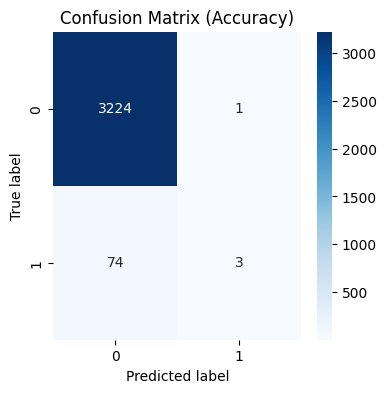

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target']

# Convert the target variable to a numpy array
y_true = np.array(y_true)

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_true, test_size=0.20, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# Define the neural network architecture with L2 regularization
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.8)))
model.add(Dense(1, activation='sigmoid'))
# Compile the model with RMSprop optimizer
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(lr=0.002, rho=0.8)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

# Train the model with early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])

# Predict the class probabilities on the test set
y_prob = model.predict(X_test)

# Collect ROC AUC, accuracy, and threshold values
aucs = []
accuracies = []
thresholds = np.arange(0.01, 1, 0.01)
for threshold in thresholds:
    # Threshold the probabilities to get binary predictions using the current threshold
    y_pred = (y_prob > threshold).astype(int)

    # Evaluate the model's performance using the current threshold
    auc = roc_auc_score(y_test, y_pred)
    aucs.append(auc)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Draw the ROC AUC and accuracy curves
fig, ax = plt.subplots()
ax.plot(thresholds, aucs, label='ROC AUC')
ax.plot(thresholds, accuracies, label='Accuracy')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold vs. Score')
ax.legend()
plt.show()

# Find the threshold that maximizes the ROC AUC and the accuracy
max_auc = max(aucs)
max_idx = aucs.index(max_auc)
best_auc_threshold = thresholds[max_idx]

max_acc = max(accuracies)
max_idx = accuracies.index(max_acc)
best_acc_threshold = thresholds[max_idx]

print("Best threshold (AUC):", best_auc_threshold)
print("Max ROC AUC:", max_auc)

print("Best threshold (Accuracy):", best_acc_threshold)
print("Max Accuracy:",max_acc)

# Threshold the probabilities to get binary predictions using the best threshold for ROC AUC
y_pred_auc = (y_prob > best_auc_threshold).astype(int)

# Evaluate the model's performance using the best threshold for ROC AUC
accuracy_auc = accuracy_score(y_test, y_pred_auc)
print("Accuracy (AUC):", accuracy_auc)

cm_auc = confusion_matrix(y_test, y_pred_auc)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_auc, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (AUC)')
plt.show()

# Threshold the probabilities to get binary predictions using the best threshold for accuracy
y_pred_acc = (y_prob > best_acc_threshold).astype(int)

# Evaluate the model's performance using the best threshold for accuracy
accuracy_acc = accuracy_score(y_test, y_pred_acc)
print("Accuracy (Accuracy):", accuracy_acc)

cm_acc = confusion_matrix(y_test, y_pred_acc)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_acc, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Accuracy)')
plt.show()


# Make prediction for current situation base on 2022Q4 data

In [ ]:
t2022 = pd.read_csv("2022q4t_file.csv")
t2022 = t2022.set_index("NAME")
t2022 = t2022[cols_less_one]
t2022 = t2022.dropna()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Store the index of the t2020 DataFrame
t2022_index = t2022.index

# Drop the index from the t2020 DataFrame
X = t2022.reset_index(drop=True)

# Instantiate a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the input features
scaler.fit(X)

# Transform the input features using the scaler
X_standardized = scaler.transform(X)

# Create a new DataFrame with the standardized input features
t2022_standardized = pd.DataFrame(X_standardized, columns=X.columns)

# Set the index of the standardized DataFrame to the original index
t2022_standardized.index = t2022_index

# Use the standardized DataFrame for further analysis
t2022 = t2022_standardized


In [ ]:

# Define the input features and target variable
X_new = t2022
# Scale the input features using the same StandardScaler as before
X_new_scaled = scaler.transform(X_new)

# Use the trained model to make predictions on the new data

y_new_prob = model.predict(X_new_scaled)
y_new_pred = (y_new_prob > 0.03).astype(int)

# Find the rows of the new data that are predicted as 1 and convert to a new DataFrame
df_predicted_ones = pd.DataFrame(t2022[y_new_pred == 1])

# Print out the predicted 1s
print('Predicted 1s:')
print(df_predicted_ones)

# Find the rows of the new data that are predicted as 1
predicted_ones = t2022.loc[y_new_pred.flatten() == 1]

# Print out the rows of t2020 that are predicted as 1
print(predicted_ones.index.to_frame(index=False))

# Save the predicted 1s names and other columns to a CSV file
predicted_ones.reset_index(inplace=True)
predicted_ones.to_csv('predicted_ones.csv', index=False)


149/149 [==============================] - 0s 1ms/step
Predicted 1s:
                              ADDNONII  ADDNONINTEXP      ASSET    EDEPDOM  \
NAME                                                                         
FIRST-CITIZENS BANK&TRUST CO   2210319       1467598  109180139   335422.0   
REGIONS BANK                   1418000       1193000  154203000   197000.0   
TRANSACT BANK NATIONAL ASSN       -165           814      14668       15.0   
STATE STREET BANK&TRUST CO     2222000       2209000  298020000   920000.0   
BMO HARRIS BANK NA              737982       1568950  176980258   823685.0   
...                                ...           ...        ...        ...   
CIBC NATIONAL TRUST CO           -2171        -26932     342946        1.0   
NORTHERN TRUST CO               300967       1962546  154522864   251582.0   
VALLEY NATIONAL BANK            171490        324449   57451653   256400.0   
LOCAL BANK                           1           325      31655       18.

In [ ]:
bank_names = ['SILICON VALLEY BANK', 'FIRST REPUBLIC BANK', 'SIGNATURE BANK', 'SILVERGATE BANK']

# Test if the DataFrame contains the bank names
contains_bank_names = predicted_ones['NAME'].str.contains('|'.join(bank_names), case=False)

# Count the occurrences of True
count_true = contains_bank_names.sum()

print(count_true)

4


## reduce the randomness of neural network sellection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

# Define the input features (i.e., the independent variables)
X = new_df[cols_less_one]

# Define the target variable (i.e., the dependent variable)
y_true = new_df['target']

# Convert the target variable to a numpy array
y_true = np.array(y_true)

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Load the new data into a DataFrame
t2022 = pd.read_csv("2022q4t_file.csv")
t2022 = t2022.set_index("NAME")
t2022 = t2022[cols_less_one]
t2022 = t2022.dropna()
new_data = t2022

# Save the index of the new data
new_data_index = new_data.index

# Define an empty DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['index', 'prediction'])

# Set the number of iterations
num_iterations = 50

# Loop through the specified number of iterations
for i in range(num_iterations):
    print(f"Iteration {i+1} of {num_iterations}")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_true, test_size=0.20, random_state=i)

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=i)

    # Define the neural network architecture with L2 regularization
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.8)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with RMSprop optimizer
    rmsprop = RMSprop(lr=0.002, rho=0.8)
    model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

    # Train the model with early stopping to prevent overfitting
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])

    # Standardize the new data using the same scaler as before
    new_data_scaled = scaler.transform(new_data[cols_less_one])

    # Predict the class probabilities on the new data
    y_prob = model.predict(new_data_scaled)

    # Threshold the probabilities to get binary predictions
    threshold = 0.03 # Use the same threshold value as during training
    y_pred = (y_prob > threshold).astype(int)

    # Store the predictions in the DataFrame
    for j in range(len(new_data_index)):
      if y_pred[j] == 1:
          predictions_df.loc[len(predictions_df)] = [new_data_index[j], y_pred[j]]

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

Iteration 1 of 50
Epoch 1/100
331/331 [==============================] - 3s 6ms/step - loss: 2.7209 - accuracy: 0.9407 - val_loss: 0.1877 - val_accuracy: 0.9761
Epoch 2/100
331/331 [==============================] - 2s 5ms/step - loss: 0.1138 - accuracy: 0.9802 - val_loss: 0.1136 - val_accuracy: 0.9761
Epoch 3/100
331/331 [==============================] - 2s 5ms/step - loss: 0.0939 - accuracy: 0.9802 - val_loss: 0.1098 - val_accuracy: 0.9758
Epoch 4/100
331/331 [==============================] - 2s 6ms/step - loss: 0.0936 - accuracy: 0.9802 - val_loss: 0.1080 - val_accuracy: 0.9761
Epoch 5/100
331/331 [==============================] - 2s 7ms/step - loss: 0.0936 - accuracy: 0.9802 - val_loss: 0.1096 - val_accuracy: 0.9761
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0937 - accuracy: 0.9802 - val_loss: 0.1090 - val_accuracy: 0.9761
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0935 - accuracy: 0.9802 - val_loss: 0.1082 - va

Iteration 2 of 50
Epoch 1/100
331/331 [==============================] - 1s 2ms/step - loss: 2.7376 - accuracy: 0.9375 - val_loss: 0.2667 - val_accuracy: 0.9799
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1578 - accuracy: 0.9804 - val_loss: 0.1029 - val_accuracy: 0.9799
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0944 - accuracy: 0.9804 - val_loss: 0.0951 - val_accuracy: 0.9799
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0923 - accuracy: 0.9804 - val_loss: 0.0960 - val_accuracy: 0.9799
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0935 - accuracy: 0.9804 - val_loss: 0.1026 - val_accuracy: 0.9799
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0923 - accuracy: 0.9804 - val_loss: 0.0957 - val_accuracy: 0.9799
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0934 - accuracy: 0.9804 - val_loss: 0.0955 - va

Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.8111 - accuracy: 0.8871 - val_loss: 0.2991 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1765 - accuracy: 0.9789 - val_loss: 0.1088 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9789 - val_loss: 0.0999 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1002 - accuracy: 0.9789 - val_loss: 0.0996 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0998 - accuracy: 0.9789 - val_loss: 0.1013 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0993 - accuracy: 0.9789 - val_loss: 0.1011 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0995 - accuracy: 0.9789 - val_loss: 0.1006 - val_accuracy: 0.9784

Iteration 4 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.6471 - accuracy: 0.9751 - val_loss: 0.1584 - val_accuracy: 0.9799
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1089 - accuracy: 0.9799 - val_loss: 0.0922 - val_accuracy: 0.9799
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0940 - accuracy: 0.9799 - val_loss: 0.0933 - val_accuracy: 0.9799
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0943 - accuracy: 0.9799 - val_loss: 0.0957 - val_accuracy: 0.9799
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0949 - accuracy: 0.9799 - val_loss: 0.0914 - val_accuracy: 0.9799
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0945 - accuracy: 0.9799 - val_loss: 0.0944 - val_accuracy: 0.9799
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0950 - accuracy: 0.9799 - val_loss: 0.0902 - va

Iteration 5 of 50
Epoch 1/100
331/331 [==============================] - 2s 5ms/step - loss: 2.7450 - accuracy: 0.9382 - val_loss: 0.2090 - val_accuracy: 0.9811
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1272 - accuracy: 0.9806 - val_loss: 0.0905 - val_accuracy: 0.9811
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0920 - accuracy: 0.9806 - val_loss: 0.0887 - val_accuracy: 0.9811
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0922 - accuracy: 0.9806 - val_loss: 0.0893 - val_accuracy: 0.9811
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0921 - accuracy: 0.9806 - val_loss: 0.0884 - val_accuracy: 0.9811
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0916 - accuracy: 0.9806 - val_loss: 0.0883 - val_accuracy: 0.9811
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0913 - accuracy: 0.9806 - val_loss: 0.0918 - va

Iteration 6 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7977 - accuracy: 0.9644 - val_loss: 0.2098 - val_accuracy: 0.9788
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1294 - accuracy: 0.9784 - val_loss: 0.0990 - val_accuracy: 0.9788
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1001 - accuracy: 0.9784 - val_loss: 0.0972 - val_accuracy: 0.9788
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1010 - accuracy: 0.9784 - val_loss: 0.0947 - val_accuracy: 0.9788
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1007 - accuracy: 0.9784 - val_loss: 0.0967 - val_accuracy: 0.9788
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1007 - accuracy: 0.9784 - val_loss: 0.0986 - val_accuracy: 0.9788
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1007 - accuracy: 0.9784 - val_loss: 0.0940 - va

Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.5868 - accuracy: 0.9519 - val_loss: 0.1712 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1097 - accuracy: 0.9801 - val_loss: 0.0973 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0926 - accuracy: 0.9801 - val_loss: 0.1038 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0922 - accuracy: 0.9801 - val_loss: 0.1010 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0921 - accuracy: 0.9801 - val_loss: 0.1005 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0921 - accuracy: 0.9801 - val_loss: 0.0991 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0917 - accuracy: 0.9801 - val_loss: 0.1024 - val_accuracy: 0.9784

Iteration 8 of 50
Epoch 1/100
331/331 [==============================] - 1s 2ms/step - loss: 2.7684 - accuracy: 0.9543 - val_loss: 0.2104 - val_accuracy: 0.9769
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1229 - accuracy: 0.9810 - val_loss: 0.1059 - val_accuracy: 0.9769
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0905 - accuracy: 0.9810 - val_loss: 0.1051 - val_accuracy: 0.9769
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0909 - accuracy: 0.9810 - val_loss: 0.1077 - val_accuracy: 0.9769
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0912 - accuracy: 0.9810 - val_loss: 0.1062 - val_accuracy: 0.9769
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0915 - accuracy: 0.9810 - val_loss: 0.1038 - val_accuracy: 0.9769
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0910 - accuracy: 0.9810 - val_loss: 0.1039 - va

Iteration 9 of 50
Epoch 1/100
331/331 [==============================] - 2s 4ms/step - loss: 2.8316 - accuracy: 0.8447 - val_loss: 0.2666 - val_accuracy: 0.9818
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1621 - accuracy: 0.9783 - val_loss: 0.0971 - val_accuracy: 0.9818
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1011 - accuracy: 0.9783 - val_loss: 0.0874 - val_accuracy: 0.9818
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1006 - accuracy: 0.9783 - val_loss: 0.0865 - val_accuracy: 0.9818
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1001 - accuracy: 0.9783 - val_loss: 0.0863 - val_accuracy: 0.9818
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1002 - accuracy: 0.9783 - val_loss: 0.0866 - val_accuracy: 0.9818
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0996 - accuracy: 0.9783 - val_loss: 0.0860 - va

Iteration 10 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7357 - accuracy: 0.9726 - val_loss: 0.1886 - val_accuracy: 0.9777
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1142 - accuracy: 0.9805 - val_loss: 0.1003 - val_accuracy: 0.9777
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0938 - accuracy: 0.9805 - val_loss: 0.1016 - val_accuracy: 0.9777
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0941 - accuracy: 0.9805 - val_loss: 0.1000 - val_accuracy: 0.9777
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0932 - accuracy: 0.9805 - val_loss: 0.1060 - val_accuracy: 0.9777
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0925 - accuracy: 0.9805 - val_loss: 0.1023 - val_accuracy: 0.9777
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0934 - accuracy: 0.9805 - val_loss: 0.1004 - v

Iteration 11 of 50
Epoch 1/100
331/331 [==============================] - 1s 2ms/step - loss: 2.7071 - accuracy: 0.9372 - val_loss: 0.2226 - val_accuracy: 0.9796
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1364 - accuracy: 0.9780 - val_loss: 0.0953 - val_accuracy: 0.9796
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1024 - accuracy: 0.9780 - val_loss: 0.0952 - val_accuracy: 0.9796
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1023 - accuracy: 0.9780 - val_loss: 0.0931 - val_accuracy: 0.9796
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9780 - val_loss: 0.0934 - val_accuracy: 0.9796
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1032 - accuracy: 0.9779 - val_loss: 0.0925 - val_accuracy: 0.9796
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1024 - accuracy: 0.9780 - val_loss: 0.0937 - v

Iteration 12 of 50
Epoch 1/100
331/331 [==============================] - 1s 2ms/step - loss: 2.6694 - accuracy: 0.9481 - val_loss: 0.2822 - val_accuracy: 0.9773
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1665 - accuracy: 0.9805 - val_loss: 0.1109 - val_accuracy: 0.9773
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0955 - accuracy: 0.9805 - val_loss: 0.1037 - val_accuracy: 0.9773
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0934 - accuracy: 0.9805 - val_loss: 0.1051 - val_accuracy: 0.9773
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0944 - accuracy: 0.9805 - val_loss: 0.1033 - val_accuracy: 0.9773
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0931 - accuracy: 0.9805 - val_loss: 0.1022 - val_accuracy: 0.9773
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0932 - accuracy: 0.9805 - val_loss: 0.1029 - v

Iteration 13 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7621 - accuracy: 0.9085 - val_loss: 0.3074 - val_accuracy: 0.9796
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1791 - accuracy: 0.9791 - val_loss: 0.1095 - val_accuracy: 0.9796
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1001 - accuracy: 0.9791 - val_loss: 0.0977 - val_accuracy: 0.9796
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0972 - accuracy: 0.9791 - val_loss: 0.0987 - val_accuracy: 0.9796
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9791 - val_loss: 0.0982 - val_accuracy: 0.9796
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0970 - accuracy: 0.9791 - val_loss: 0.0979 - val_accuracy: 0.9796
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0970 - accuracy: 0.9791 - val_loss: 0.0978 - v

Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.6891 - accuracy: 0.8943 - val_loss: 0.2804 - val_accuracy: 0.9777
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1634 - accuracy: 0.9793 - val_loss: 0.1089 - val_accuracy: 0.9777
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0989 - accuracy: 0.9793 - val_loss: 0.1010 - val_accuracy: 0.9777
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0979 - accuracy: 0.9793 - val_loss: 0.1009 - val_accuracy: 0.9777
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0982 - accuracy: 0.9793 - val_loss: 0.1026 - val_accuracy: 0.9777
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0977 - accuracy: 0.9793 - val_loss: 0.1044 - val_accuracy: 0.9777
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0982 - accuracy: 0.9793 - val_loss: 0.1017 - val_accuracy: 0.9777

Iteration 15 of 50
Epoch 1/100
331/331 [==============================] - 2s 3ms/step - loss: 2.5344 - accuracy: 0.9680 - val_loss: 0.1604 - val_accuracy: 0.9780
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1136 - accuracy: 0.9782 - val_loss: 0.1005 - val_accuracy: 0.9780
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9781 - val_loss: 0.1017 - val_accuracy: 0.9780
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1010 - accuracy: 0.9782 - val_loss: 0.0991 - val_accuracy: 0.9780
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1015 - accuracy: 0.9782 - val_loss: 0.0990 - val_accuracy: 0.9780
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1024 - accuracy: 0.9782 - val_loss: 0.0966 - val_accuracy: 0.9780
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1003 - accuracy: 0.9782 - val_loss: 0.0966 - v

Iteration 16 of 50
Epoch 1/100
331/331 [==============================] - 1s 2ms/step - loss: 2.7161 - accuracy: 0.9264 - val_loss: 0.2246 - val_accuracy: 0.9807
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1409 - accuracy: 0.9782 - val_loss: 0.0926 - val_accuracy: 0.9807
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1010 - accuracy: 0.9782 - val_loss: 0.0951 - val_accuracy: 0.9807
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1013 - accuracy: 0.9782 - val_loss: 0.0889 - val_accuracy: 0.9807
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1013 - accuracy: 0.9782 - val_loss: 0.0890 - val_accuracy: 0.9807
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1011 - accuracy: 0.9782 - val_loss: 0.0884 - val_accuracy: 0.9807
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1009 - accuracy: 0.9782 - val_loss: 0.0920 - v

Iteration 17 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.9717 - accuracy: 0.8777 - val_loss: 0.3011 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1848 - accuracy: 0.9798 - val_loss: 0.1154 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0989 - accuracy: 0.9799 - val_loss: 0.0983 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0945 - accuracy: 0.9799 - val_loss: 0.0974 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0945 - accuracy: 0.9799 - val_loss: 0.0976 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0946 - accuracy: 0.9799 - val_loss: 0.0976 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0949 - accuracy: 0.9799 - val_loss: 0.0970 - v

Iteration 18 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7909 - accuracy: 0.9586 - val_loss: 0.1967 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1189 - accuracy: 0.9804 - val_loss: 0.0993 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0931 - accuracy: 0.9804 - val_loss: 0.0982 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0929 - accuracy: 0.9804 - val_loss: 0.0987 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0927 - accuracy: 0.9804 - val_loss: 0.0976 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0924 - accuracy: 0.9804 - val_loss: 0.1001 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0931 - accuracy: 0.9804 - val_loss: 0.0997 - v

Iteration 19 of 50
Epoch 1/100
331/331 [==============================] - 1s 2ms/step - loss: 2.8841 - accuracy: 0.8600 - val_loss: 0.3269 - val_accuracy: 0.9780
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1906 - accuracy: 0.9791 - val_loss: 0.1146 - val_accuracy: 0.9780
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1013 - accuracy: 0.9791 - val_loss: 0.1013 - val_accuracy: 0.9780
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0996 - accuracy: 0.9791 - val_loss: 0.1025 - val_accuracy: 0.9780
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0995 - accuracy: 0.9791 - val_loss: 0.1022 - val_accuracy: 0.9780
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0996 - accuracy: 0.9791 - val_loss: 0.1034 - val_accuracy: 0.9780
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0999 - accuracy: 0.9791 - val_loss: 0.1009 - v

Epoch 1/100
331/331 [==============================] - 2s 4ms/step - loss: 2.8849 - accuracy: 0.8597 - val_loss: 0.2740 - val_accuracy: 0.9769
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1600 - accuracy: 0.9800 - val_loss: 0.1107 - val_accuracy: 0.9769
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0957 - accuracy: 0.9800 - val_loss: 0.1055 - val_accuracy: 0.9769
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0943 - accuracy: 0.9800 - val_loss: 0.1048 - val_accuracy: 0.9769
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0942 - accuracy: 0.9800 - val_loss: 0.1048 - val_accuracy: 0.9769
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0940 - accuracy: 0.9800 - val_loss: 0.1045 - val_accuracy: 0.9769
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0937 - accuracy: 0.9800 - val_loss: 0.1055 - val_accuracy: 0.9769

Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7137 - accuracy: 0.9154 - val_loss: 0.2296 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1381 - accuracy: 0.9778 - val_loss: 0.1015 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1035 - accuracy: 0.9778 - val_loss: 0.1009 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1036 - accuracy: 0.9778 - val_loss: 0.1005 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1025 - accuracy: 0.9778 - val_loss: 0.1000 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9778 - val_loss: 0.1004 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1034 - accuracy: 0.9778 - val_loss: 0.1041 - val_accuracy: 0.9784

Iteration 22 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.5454 - accuracy: 0.9759 - val_loss: 0.1119 - val_accuracy: 0.9845
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1042 - accuracy: 0.9782 - val_loss: 0.0744 - val_accuracy: 0.9845
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1001 - accuracy: 0.9782 - val_loss: 0.0747 - val_accuracy: 0.9845
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1000 - accuracy: 0.9782 - val_loss: 0.0764 - val_accuracy: 0.9845
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1000 - accuracy: 0.9782 - val_loss: 0.0746 - val_accuracy: 0.9845
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0997 - accuracy: 0.9782 - val_loss: 0.0743 - val_accuracy: 0.9845
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0996 - accuracy: 0.9782 - val_loss: 0.0733 - v

Epoch 1/100
331/331 [==============================] - 2s 4ms/step - loss: 2.6912 - accuracy: 0.9778 - val_loss: 0.1431 - val_accuracy: 0.9743
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1024 - accuracy: 0.9801 - val_loss: 0.1108 - val_accuracy: 0.9743
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0947 - accuracy: 0.9801 - val_loss: 0.1126 - val_accuracy: 0.9743
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0938 - accuracy: 0.9801 - val_loss: 0.1130 - val_accuracy: 0.9743
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0946 - accuracy: 0.9801 - val_loss: 0.1162 - val_accuracy: 0.9743
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0943 - accuracy: 0.9801 - val_loss: 0.1125 - val_accuracy: 0.9743
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0947 - accuracy: 0.9801 - val_loss: 0.1141 - val_accuracy: 0.9743

Iteration 24 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.9168 - accuracy: 0.9058 - val_loss: 0.2400 - val_accuracy: 0.9758
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1350 - accuracy: 0.9811 - val_loss: 0.1122 - val_accuracy: 0.9758
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0906 - accuracy: 0.9811 - val_loss: 0.1101 - val_accuracy: 0.9758
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0901 - accuracy: 0.9811 - val_loss: 0.1118 - val_accuracy: 0.9758
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0899 - accuracy: 0.9811 - val_loss: 0.1195 - val_accuracy: 0.9758
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0900 - accuracy: 0.9811 - val_loss: 0.1122 - val_accuracy: 0.9758
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0896 - accuracy: 0.9811 - val_loss: 0.1138 - v

Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.6336 - accuracy: 0.9368 - val_loss: 0.2325 - val_accuracy: 0.9788
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1415 - accuracy: 0.9786 - val_loss: 0.1010 - val_accuracy: 0.9788
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0995 - accuracy: 0.9786 - val_loss: 0.0979 - val_accuracy: 0.9788
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0997 - accuracy: 0.9786 - val_loss: 0.0989 - val_accuracy: 0.9788
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0987 - accuracy: 0.9786 - val_loss: 0.0986 - val_accuracy: 0.9788
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0986 - accuracy: 0.9786 - val_loss: 0.0974 - val_accuracy: 0.9788
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0997 - accuracy: 0.9785 - val_loss: 0.0973 - val_accuracy: 0.9788

Iteration 26 of 50
Epoch 1/100
331/331 [==============================] - 2s 4ms/step - loss: 2.8472 - accuracy: 0.8954 - val_loss: 0.2713 - val_accuracy: 0.9818
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1575 - accuracy: 0.9805 - val_loss: 0.0969 - val_accuracy: 0.9818
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0945 - accuracy: 0.9805 - val_loss: 0.0904 - val_accuracy: 0.9818
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0926 - accuracy: 0.9805 - val_loss: 0.0903 - val_accuracy: 0.9818
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0929 - accuracy: 0.9805 - val_loss: 0.0896 - val_accuracy: 0.9818
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0934 - accuracy: 0.9805 - val_loss: 0.0898 - val_accuracy: 0.9818
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0922 - accuracy: 0.9805 - val_loss: 0.0887 - v

Iteration 27 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.6845 - accuracy: 0.9748 - val_loss: 0.1668 - val_accuracy: 0.9777
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1123 - accuracy: 0.9790 - val_loss: 0.1024 - val_accuracy: 0.9777
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0992 - accuracy: 0.9790 - val_loss: 0.1018 - val_accuracy: 0.9777
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0981 - accuracy: 0.9790 - val_loss: 0.1042 - val_accuracy: 0.9777
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0991 - accuracy: 0.9790 - val_loss: 0.1029 - val_accuracy: 0.9777
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0984 - accuracy: 0.9790 - val_loss: 0.1035 - val_accuracy: 0.9777
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0986 - accuracy: 0.9790 - val_loss: 0.1020 - v

Iteration 28 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.9083 - accuracy: 0.8093 - val_loss: 0.3579 - val_accuracy: 0.9788
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.2299 - accuracy: 0.9785 - val_loss: 0.1369 - val_accuracy: 0.9788
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1106 - accuracy: 0.9785 - val_loss: 0.0997 - val_accuracy: 0.9788
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1007 - accuracy: 0.9785 - val_loss: 0.1002 - val_accuracy: 0.9788
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1011 - accuracy: 0.9785 - val_loss: 0.1005 - val_accuracy: 0.9788
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1008 - accuracy: 0.9785 - val_loss: 0.0989 - val_accuracy: 0.9788
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1011 - accuracy: 0.9785 - val_loss: 0.1000 - v

Iteration 29 of 50
Epoch 1/100
331/331 [==============================] - 2s 4ms/step - loss: 2.7532 - accuracy: 0.9583 - val_loss: 0.1613 - val_accuracy: 0.9792
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1134 - accuracy: 0.9787 - val_loss: 0.0948 - val_accuracy: 0.9792
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0989 - accuracy: 0.9787 - val_loss: 0.0942 - val_accuracy: 0.9792
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0994 - accuracy: 0.9787 - val_loss: 0.0914 - val_accuracy: 0.9792
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0992 - accuracy: 0.9787 - val_loss: 0.0913 - val_accuracy: 0.9792
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0993 - accuracy: 0.9787 - val_loss: 0.0925 - val_accuracy: 0.9792
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0988 - accuracy: 0.9787 - val_loss: 0.0946 - v

Iteration 30 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.8838 - accuracy: 0.8628 - val_loss: 0.2878 - val_accuracy: 0.9803
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1750 - accuracy: 0.9781 - val_loss: 0.1057 - val_accuracy: 0.9803
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1025 - accuracy: 0.9781 - val_loss: 0.0954 - val_accuracy: 0.9803
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1007 - accuracy: 0.9781 - val_loss: 0.0946 - val_accuracy: 0.9803
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1010 - accuracy: 0.9781 - val_loss: 0.0942 - val_accuracy: 0.9803
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1001 - accuracy: 0.9781 - val_loss: 0.0940 - val_accuracy: 0.9803
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0999 - accuracy: 0.9781 - val_loss: 0.0961 - v

Iteration 31 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.6367 - accuracy: 0.9663 - val_loss: 0.1760 - val_accuracy: 0.9807
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1162 - accuracy: 0.9793 - val_loss: 0.0923 - val_accuracy: 0.9807
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0963 - accuracy: 0.9793 - val_loss: 0.0926 - val_accuracy: 0.9807
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0964 - accuracy: 0.9793 - val_loss: 0.0915 - val_accuracy: 0.9807
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0966 - accuracy: 0.9793 - val_loss: 0.0912 - val_accuracy: 0.9807
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0961 - accuracy: 0.9793 - val_loss: 0.0924 - val_accuracy: 0.9807
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0960 - accuracy: 0.9793 - val_loss: 0.0900 - v

Iteration 32 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.6882 - accuracy: 0.9386 - val_loss: 0.2131 - val_accuracy: 0.9811
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1306 - accuracy: 0.9796 - val_loss: 0.0923 - val_accuracy: 0.9811
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0954 - accuracy: 0.9796 - val_loss: 0.0921 - val_accuracy: 0.9811
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0954 - accuracy: 0.9796 - val_loss: 0.0891 - val_accuracy: 0.9811
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0951 - accuracy: 0.9796 - val_loss: 0.0886 - val_accuracy: 0.9811
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0960 - accuracy: 0.9796 - val_loss: 0.0892 - val_accuracy: 0.9811
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0953 - accuracy: 0.9796 - val_loss: 0.0901 - v

Iteration 33 of 50
Epoch 1/100
331/331 [==============================] - 2s 4ms/step - loss: 2.7896 - accuracy: 0.9061 - val_loss: 0.2890 - val_accuracy: 0.9792
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1721 - accuracy: 0.9788 - val_loss: 0.1048 - val_accuracy: 0.9792
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1010 - accuracy: 0.9788 - val_loss: 0.0973 - val_accuracy: 0.9792
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0991 - accuracy: 0.9788 - val_loss: 0.0971 - val_accuracy: 0.9792
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1003 - accuracy: 0.9788 - val_loss: 0.0969 - val_accuracy: 0.9792
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1002 - accuracy: 0.9788 - val_loss: 0.0990 - val_accuracy: 0.9792
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1006 - accuracy: 0.9788 - val_loss: 0.0985 - v

Iteration 34 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7535 - accuracy: 0.9063 - val_loss: 0.2366 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1410 - accuracy: 0.9788 - val_loss: 0.1014 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0990 - accuracy: 0.9788 - val_loss: 0.1016 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1000 - accuracy: 0.9788 - val_loss: 0.0984 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 4ms/step - loss: 0.1004 - accuracy: 0.9788 - val_loss: 0.1015 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0992 - accuracy: 0.9788 - val_loss: 0.0987 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0996 - accuracy: 0.9788 - val_loss: 0.0996 - v

Iteration 35 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.8874 - accuracy: 0.9225 - val_loss: 0.2309 - val_accuracy: 0.9799
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1393 - accuracy: 0.9795 - val_loss: 0.0954 - val_accuracy: 0.9799
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0968 - accuracy: 0.9795 - val_loss: 0.0932 - val_accuracy: 0.9799
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0964 - accuracy: 0.9795 - val_loss: 0.0913 - val_accuracy: 0.9799
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0964 - accuracy: 0.9795 - val_loss: 0.0917 - val_accuracy: 0.9799
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0965 - accuracy: 0.9795 - val_loss: 0.0910 - val_accuracy: 0.9799
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0962 - accuracy: 0.9795 - val_loss: 0.0921 - v

Iteration 36 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7288 - accuracy: 0.9364 - val_loss: 0.1747 - val_accuracy: 0.9826
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1185 - accuracy: 0.9782 - val_loss: 0.0902 - val_accuracy: 0.9826
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0993 - accuracy: 0.9782 - val_loss: 0.0864 - val_accuracy: 0.9826
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0987 - accuracy: 0.9782 - val_loss: 0.0850 - val_accuracy: 0.9826
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0990 - accuracy: 0.9782 - val_loss: 0.0850 - val_accuracy: 0.9826
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0991 - accuracy: 0.9782 - val_loss: 0.0849 - val_accuracy: 0.9826
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0985 - accuracy: 0.9782 - val_loss: 0.0860 - v

Iteration 37 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.6023 - accuracy: 0.9581 - val_loss: 0.1615 - val_accuracy: 0.9803
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1128 - accuracy: 0.9790 - val_loss: 0.0899 - val_accuracy: 0.9803
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0985 - accuracy: 0.9790 - val_loss: 0.0931 - val_accuracy: 0.9803
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0991 - accuracy: 0.9790 - val_loss: 0.0885 - val_accuracy: 0.9803
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0973 - accuracy: 0.9790 - val_loss: 0.0908 - val_accuracy: 0.9803
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0997 - accuracy: 0.9790 - val_loss: 0.0900 - val_accuracy: 0.9803
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0975 - accuracy: 0.9790 - val_loss: 0.0882 - v

Iteration 38 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.8636 - accuracy: 0.8960 - val_loss: 0.2994 - val_accuracy: 0.9852
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1797 - accuracy: 0.9787 - val_loss: 0.0895 - val_accuracy: 0.9852
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1018 - accuracy: 0.9787 - val_loss: 0.0759 - val_accuracy: 0.9852
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0997 - accuracy: 0.9787 - val_loss: 0.0753 - val_accuracy: 0.9852
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1002 - accuracy: 0.9787 - val_loss: 0.0752 - val_accuracy: 0.9852
Epoch 6/100
331/331 [==============================] - 1s 4ms/step - loss: 0.1002 - accuracy: 0.9787 - val_loss: 0.0763 - val_accuracy: 0.9852
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1001 - accuracy: 0.9787 - val_loss: 0.0750 - v

Iteration 39 of 50
Epoch 1/100
331/331 [==============================] - 2s 4ms/step - loss: 2.8572 - accuracy: 0.9199 - val_loss: 0.2084 - val_accuracy: 0.9811
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1330 - accuracy: 0.9784 - val_loss: 0.0927 - val_accuracy: 0.9811
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1007 - accuracy: 0.9784 - val_loss: 0.0897 - val_accuracy: 0.9811
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0990 - accuracy: 0.9784 - val_loss: 0.0900 - val_accuracy: 0.9811
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1007 - accuracy: 0.9784 - val_loss: 0.0873 - val_accuracy: 0.9811
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1007 - accuracy: 0.9784 - val_loss: 0.0903 - val_accuracy: 0.9811
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0994 - accuracy: 0.9784 - val_loss: 0.0872 - v

Iteration 40 of 50
Epoch 1/100
331/331 [==============================] - 2s 3ms/step - loss: 2.9042 - accuracy: 0.8614 - val_loss: 0.3217 - val_accuracy: 0.9814
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.2019 - accuracy: 0.9785 - val_loss: 0.1178 - val_accuracy: 0.9814
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1051 - accuracy: 0.9785 - val_loss: 0.0908 - val_accuracy: 0.9814
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0993 - accuracy: 0.9785 - val_loss: 0.0910 - val_accuracy: 0.9814
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0989 - accuracy: 0.9785 - val_loss: 0.0898 - val_accuracy: 0.9814
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0988 - accuracy: 0.9785 - val_loss: 0.0903 - val_accuracy: 0.9814
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0985 - accuracy: 0.9785 - val_loss: 0.0901 - v

Iteration 41 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.8973 - accuracy: 0.9343 - val_loss: 0.2117 - val_accuracy: 0.9822
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1296 - accuracy: 0.9795 - val_loss: 0.0867 - val_accuracy: 0.9826
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0977 - accuracy: 0.9795 - val_loss: 0.0842 - val_accuracy: 0.9822
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0973 - accuracy: 0.9794 - val_loss: 0.0838 - val_accuracy: 0.9826
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0974 - accuracy: 0.9795 - val_loss: 0.0857 - val_accuracy: 0.9826
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0978 - accuracy: 0.9795 - val_loss: 0.0836 - val_accuracy: 0.9826
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9795 - val_loss: 0.0851 - v

Iteration 42 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7265 - accuracy: 0.9581 - val_loss: 0.2053 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1238 - accuracy: 0.9803 - val_loss: 0.1020 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0940 - accuracy: 0.9803 - val_loss: 0.1000 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0942 - accuracy: 0.9803 - val_loss: 0.1024 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0945 - accuracy: 0.9803 - val_loss: 0.1015 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0945 - accuracy: 0.9803 - val_loss: 0.0983 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0943 - accuracy: 0.9803 - val_loss: 0.0967 - v

Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.6957 - accuracy: 0.9635 - val_loss: 0.1930 - val_accuracy: 0.9803
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1205 - accuracy: 0.9796 - val_loss: 0.0963 - val_accuracy: 0.9803
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0962 - accuracy: 0.9796 - val_loss: 0.0949 - val_accuracy: 0.9803
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0956 - accuracy: 0.9796 - val_loss: 0.0946 - val_accuracy: 0.9803
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0945 - accuracy: 0.9796 - val_loss: 0.0932 - val_accuracy: 0.9803
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0956 - accuracy: 0.9796 - val_loss: 0.0937 - val_accuracy: 0.9803
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0946 - accuracy: 0.9796 - val_loss: 0.0942 - val_accuracy: 0.9803

Iteration 44 of 50
Epoch 1/100
331/331 [==============================] - 2s 4ms/step - loss: 2.4882 - accuracy: 0.9756 - val_loss: 0.1586 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1067 - accuracy: 0.9794 - val_loss: 0.0993 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0957 - accuracy: 0.9794 - val_loss: 0.1009 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0960 - accuracy: 0.9794 - val_loss: 0.1011 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0963 - accuracy: 0.9794 - val_loss: 0.1015 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0952 - accuracy: 0.9794 - val_loss: 0.1004 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0955 - accuracy: 0.9794 - val_loss: 0.1007 - v

Iteration 45 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.8241 - accuracy: 0.9231 - val_loss: 0.2461 - val_accuracy: 0.9799
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1468 - accuracy: 0.9785 - val_loss: 0.1015 - val_accuracy: 0.9799
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1008 - accuracy: 0.9785 - val_loss: 0.0946 - val_accuracy: 0.9799
Epoch 4/100
331/331 [==============================] - 1s 4ms/step - loss: 0.1001 - accuracy: 0.9785 - val_loss: 0.0956 - val_accuracy: 0.9799
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 0.1003 - accuracy: 0.9785 - val_loss: 0.0950 - val_accuracy: 0.9799
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1006 - accuracy: 0.9785 - val_loss: 0.0958 - val_accuracy: 0.9799
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0998 - accuracy: 0.9785 - val_loss: 0.0950 - v

Iteration 46 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7733 - accuracy: 0.9650 - val_loss: 0.1740 - val_accuracy: 0.9780
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1147 - accuracy: 0.9790 - val_loss: 0.1009 - val_accuracy: 0.9780
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0986 - accuracy: 0.9790 - val_loss: 0.0971 - val_accuracy: 0.9780
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0978 - accuracy: 0.9790 - val_loss: 0.1003 - val_accuracy: 0.9780
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0980 - accuracy: 0.9790 - val_loss: 0.0976 - val_accuracy: 0.9780
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9790 - val_loss: 0.0972 - val_accuracy: 0.9780
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9790 - val_loss: 0.0972 - v

Iteration 47 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.9757 - accuracy: 0.8152 - val_loss: 0.3686 - val_accuracy: 0.9818
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.2409 - accuracy: 0.9782 - val_loss: 0.1368 - val_accuracy: 0.9818
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1143 - accuracy: 0.9782 - val_loss: 0.0911 - val_accuracy: 0.9818
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1017 - accuracy: 0.9782 - val_loss: 0.0884 - val_accuracy: 0.9818
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1013 - accuracy: 0.9782 - val_loss: 0.0906 - val_accuracy: 0.9818
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9782 - val_loss: 0.0879 - val_accuracy: 0.9818
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1015 - accuracy: 0.9782 - val_loss: 0.0886 - v

Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.9084 - accuracy: 0.9355 - val_loss: 0.2028 - val_accuracy: 0.9792
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1281 - accuracy: 0.9785 - val_loss: 0.0976 - val_accuracy: 0.9792
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0994 - accuracy: 0.9785 - val_loss: 0.0948 - val_accuracy: 0.9792
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0995 - accuracy: 0.9785 - val_loss: 0.0938 - val_accuracy: 0.9792
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0984 - accuracy: 0.9785 - val_loss: 0.0985 - val_accuracy: 0.9792
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0988 - accuracy: 0.9785 - val_loss: 0.0949 - val_accuracy: 0.9792
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0990 - accuracy: 0.9785 - val_loss: 0.0945 - val_accuracy: 0.9792

Iteration 49 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.8816 - accuracy: 0.9051 - val_loss: 0.2507 - val_accuracy: 0.9758
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1442 - accuracy: 0.9791 - val_loss: 0.1118 - val_accuracy: 0.9758
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0982 - accuracy: 0.9791 - val_loss: 0.1093 - val_accuracy: 0.9758
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0978 - accuracy: 0.9791 - val_loss: 0.1113 - val_accuracy: 0.9758
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0979 - accuracy: 0.9791 - val_loss: 0.1093 - val_accuracy: 0.9758
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0983 - accuracy: 0.9791 - val_loss: 0.1092 - val_accuracy: 0.9758
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0978 - accuracy: 0.9791 - val_loss: 0.1091 - v

Iteration 50 of 50
Epoch 1/100
331/331 [==============================] - 1s 3ms/step - loss: 2.7972 - accuracy: 0.9079 - val_loss: 0.2885 - val_accuracy: 0.9784
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1743 - accuracy: 0.9793 - val_loss: 0.1073 - val_accuracy: 0.9784
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1009 - accuracy: 0.9793 - val_loss: 0.0981 - val_accuracy: 0.9784
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0982 - accuracy: 0.9792 - val_loss: 0.0979 - val_accuracy: 0.9784
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.0985 - accuracy: 0.9793 - val_loss: 0.1019 - val_accuracy: 0.9784
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0983 - accuracy: 0.9793 - val_loss: 0.0966 - val_accuracy: 0.9784
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 0.0983 - accuracy: 0.9793 - val_loss: 0.0976 - v

In [ ]:
pre = pd.read_csv("predictions.csv")

In [ ]:
predictions_df[predictions_df['prediction'] == 1].to_csv('predictions.csv', index=False)
pre['index'].value_counts().head(200).to_csv('predictions.csv')

In [ ]:
output_count = pd.DataFrame(pre['index'].value_counts().head(200))

In [ ]:
output_count

,index
INDEPENDENCE BANK,51
GENESIS BANK,50
EVERMORE BANK,50
GAINEY BUSINESS BANK,50
LEGACY BANK,50
...,...
NATIONWIDE TRUST CO FSB,13
PIERMONT BANK,13
GULF CAPITAL BANK,13
MIZUHO BANK USA,13


In [ ]:
contains_bank_names = output_count.index.str.contains('|'.join(bank_names), case=False)

# Count the occurrences of True
count_true = contains_bank_names.sum()

print(count_true)

4


In [ ]:
contains_bank_names

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,